In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
sns.set_style('darkgrid')

# 노트북에서 플롯을 표시
%matplotlib inline

In [14]:
def idToName(ID,dic):
    '''
    ID: 원본 데이터 프레임에 나열된 챔피언 ID
    dic: 챔프위에서 정의한 json의 정보

    ID를 챔피언 이름으로 변환하는 데 사용됩니다.
    '''
    champ = dic['name'][ID]
    return champ

def getTag(name,data):
    '''
    name: 데이터 프레임에 나열된 챔피언 이름
    데이터: 챔피언정보

    챔피언정보에게 주 태그를 받는데 사용
    '''
    tags = data['tags'][name][0]
    return tags

def numToColor(data):
    '''
    데이터: 주 데이터 프레임

    0 또는 1부터 팀의 색상을 가져오는 데 사용됩니다.
    '''
    if data == 0:
        color = 'blue'
    else:
        color = 'red'
    return color

### 오리지널 데이터 불러오기

In [15]:
data=pd.read_csv('games.csv')
data.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


### 챔피언 정보 json 가져오기 및 데이터 가져오기

In [16]:
jDict = pd.read_json('champion_info_2.json')
champInfo = pd.read_json((jDict['data']).to_json(), orient='index')
champInfo.head()

,tags,title,id,key,name
Aatrox,"[Fighter, Tank]",the Darkin Blade,266,Aatrox,Aatrox
Ahri,"[Mage, Assassin]",the Nine-Tailed Fox,103,Ahri,Ahri
Akali,[Assassin],the Fist of Shadow,84,Akali,Akali
Alistar,"[Tank, Support]",the Minotaur,12,Alistar,Alistar
Amumu,"[Tank, Mage]",the Sad Mummy,32,Amumu,Amumu


### 소환사 스펠 데이터 가져오기

In [17]:
spellJson = pd.read_json('summoner_spell_info.json')
spellInfo = pd.read_json((spellJson['data']).to_json(),orient='index')
spellInfo.head()

,id,summonerLevel,name,key,description
1,1,6,Cleanse,SummonerBoost,Removes all disables (excluding suppression an...
11,11,10,Smite,SummonerSmite,Deals 390-1000 true damage (depending on champ...
12,12,6,Teleport,SummonerTeleport,"After channeling for 4.5 seconds, teleports yo..."
13,13,1,Clarity,SummonerMana,Restores 50% of your champion's maximum Mana. ...
14,14,10,Ignite,SummonerDot,"Ignites target enemy champion, dealing 70-410 ..."


### 인덱스를 일시적으로 ID로 설정

In [18]:
champInfo.set_index(['id'], inplace=True)
champInfo.head()

,tags,title,key,name
id,,,,
266,"[Fighter, Tank]",the Darkin Blade,Aatrox,Aatrox
103,"[Mage, Assassin]",the Nine-Tailed Fox,Ahri,Ahri
84,[Assassin],the Fist of Shadow,Akali,Akali
12,"[Tank, Support]",the Minotaur,Alistar,Alistar
32,"[Tank, Mage]",the Sad Mummy,Amumu,Amumu


### 사용자 선택 열 목록과 금지에 대한 다른 목록 만들기

- 챔피언 밴 : 각 팀당 5개
- 스펠 : 각 챔피언 당 2개

In [19]:
champCols=['t1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id',
             't2_champ1id','t2_champ2id','t2_champ3id','t2_champ4id','t2_champ5id']

banCols = ['t1_ban1','t1_ban2','t1_ban3','t1_ban4','t1_ban5',
             't2_ban1','t2_ban2','t2_ban3','t2_ban4','t2_ban5',]
sumSpellsCols = ['t1_champ1_sum1','t1_champ1_sum2','t1_champ2_sum1','t1_champ2_sum2','t1_champ3_sum1','t1_champ3_sum2',
                 't1_champ4_sum1','t1_champ4_sum2','t1_champ5_sum1','t1_champ5_sum2','t2_champ1_sum1','t2_champ1_sum2',
                 't2_champ2_sum1','t2_champ2_sum2','t2_champ3_sum1','t2_champ3_sum2','t2_champ4_sum1','t2_champ4_sum2',
                 't2_champ5_sum1','t2_champ5_sum2']

### 이 열에 idToName 함수를 적용하여 ID가 아닌 챔피언 이름을 갖도록 합니다.

In [20]:
for c in champCols:
    data[c] = data[c].apply(lambda x: idToName(x, champInfo))

for c in banCols:
    data[c] = data[c].apply(lambda x: idToName(x, champInfo)) 

for c in sumSpellsCols:
    data[c] = data[c].apply(lambda x: idToName(x, spellInfo))

In [21]:
data[champCols].head()

,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id
0,Vladimir,Bard,Kog'Maw,Master Yi,Viktor,Graves,Xayah,Darius,Zed,Thresh
1,Draven,Irelia,Nidalee,Kayle,Shaco,Malphite,Morgana,Hecarim,Yasuo,Riven
2,Tristana,Kayn,Nami,Rumble,Kassadin,Cassiopeia,Thresh,Jayce,Jax,Ashe
3,Maokai,Brand,Twitch,Orianna,Dr. Mundo,Malzahar,Warwick,Thresh,Riven,Ashe
4,Warwick,Twitch,Janna,Draven,Syndra,Sona,Jarvan IV,Kayn,Kassadin,Caitlyn


In [22]:
data[banCols].head()

,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,Riven,Janna,Cassiopeia,Draven,Kayn,Fiora,Vayne,Karma,Soraka,Caitlyn
1,Caitlyn,Darius,Teemo,Xayah,Warwick,Master Yi,Vayne,Zed,Caitlyn,Illaoi
2,Lulu,Janna,Twitch,Soraka,Blitzcrank,Yasuo,Zed,Kha'Zix,Maokai,Evelynn
3,Zed,Vayne,Ornn,Fiora,Cho'Gath,Camille,Tristana,Kayn,Janna,Caitlyn
4,Malzahar,Lee Sin,Thresh,Morgana,Cho'Gath,Garen,Master Yi,Braum,Darius,Tristana


In [23]:
data[sumSpellsCols].head()

,t1_champ1_sum1,t1_champ1_sum2,t1_champ2_sum1,t1_champ2_sum2,t1_champ3_sum1,t1_champ3_sum2,t1_champ4_sum1,t1_champ4_sum2,t1_champ5_sum1,t1_champ5_sum2,t2_champ1_sum1,t2_champ1_sum2,t2_champ2_sum1,t2_champ2_sum2,t2_champ3_sum1,t2_champ3_sum2,t2_champ4_sum1,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2
0,Teleport,Flash,Exhaust,Flash,Flash,Heal,Smite,Ghost,Flash,Ignite,Smite,Flash,Flash,Heal,Ghost,Flash,Ignite,Flash,Flash,Exhaust
1,Heal,Flash,Teleport,Flash,Flash,Exhaust,Flash,Ignite,Flash,Smite,Flash,Teleport,Flash,Ignite,Smite,Flash,Flash,Ignite,Flash,Heal
2,Flash,Heal,Smite,Flash,Exhaust,Flash,Flash,Teleport,Teleport,Flash,Flash,Heal,Ignite,Flash,Flash,Teleport,Flash,Smite,Heal,Flash
3,Flash,Teleport,Flash,Ignite,Flash,Heal,Flash,Cleanse,Smite,Flash,Ignite,Flash,Smite,Flash,Flash,Exhaust,Flash,Ignite,Flash,Heal
4,Flash,Teleport,Smite,Flash,Flash,Exhaust,Flash,Heal,Heal,Flash,Exhaust,Flash,Flash,Teleport,Smite,Flash,Flash,Teleport,Flash,Heal


### champInfo 데이터 프레임 인덱스를 챔피언 이름으로 설정

In [24]:
champInfo.set_index(['name'],inplace=True)
champInfo.head()

,tags,title,key
name,,,
Aatrox,"[Fighter, Tank]",the Darkin Blade,Aatrox
Ahri,"[Mage, Assassin]",the Nine-Tailed Fox,Ahri
Akali,[Assassin],the Fist of Shadow,Akali
Alistar,"[Tank, Support]",the Minotaur,Alistar
Amumu,"[Tank, Mage]",the Sad Mummy,Amumu


### 이 열에 getTag 기능을 적용하면 새로운 기본 챔피언 태그 열이 생깁니다.

In [25]:
for col in champCols:
    data[col+'_tags']=data[col].apply(lambda x : getTag(x,champInfo))
data.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t1_champ1id_tags,t1_champ2id_tags,t1_champ3id_tags,t1_champ4id_tags,t1_champ5id_tags,t2_champ1id_tags,t2_champ2id_tags,t2_champ3id_tags,t2_champ4id_tags,t2_champ5id_tags
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,Mage,Support,Marksman,Assassin,Mage,Marksman,Marksman,Fighter,Assassin,Support
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,Marksman,Fighter,Assassin,Fighter,Assassin,Tank,Mage,Fighter,Fighter,Fighter
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,Marksman,Fighter,Support,Fighter,Assassin,Mage,Support,Fighter,Fighter,Marksman
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,Tank,Mage,Marksman,Mage,Fighter,Mage,Fighter,Support,Fighter,Marksman
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,Fighter,Marksman,Support,Marksman,Mage,Support,Tank,Fighter,Assassin,Marksman


- Mage : 마법사
- Marksman : 원거리 딜러
- Assassin : 암살자
- Support : 지원가
- Fighter : 전사
- Tanker : 탱커

### 챔피언 선택 및 금지를 살펴보겠습니다.

각 챔피언 선택에 대한 일련의 기본 태그뿐만 아니라 선택 및 금지의 정렬된 시리즈를 만듭니다.

In [26]:
sumPicks = pd.concat([data['t1_champ1id'],data['t1_champ2id'],data['t1_champ3id'],data['t1_champ4id'],data['t1_champ5id'],
                      data['t2_champ1id'],data['t2_champ2id'],data['t2_champ3id'],data['t2_champ4id'],data['t2_champ5id']],
                      ignore_index=True)
sortedPicks=sorted(sumPicks)
# sorted : 정렬된 리스트로 반환
sumBans = pd.concat([data['t1_ban1'],data['t1_ban2'],data['t1_ban3'],data['t1_ban4'],data['t1_ban5'],
                     data['t2_ban1'],data['t2_ban2'],data['t2_ban3'],data['t2_ban4'],data['t2_ban5']],
                     ignore_index=True)
sortedBans = sorted(sumBans)

### 전체 데이터 세트에 대한 총 챔피언 선택 및 금지에 대한 카운트 플롯을 만들어 보겠습니다.

Text(0.5, 1.0, 'Champion Bans')

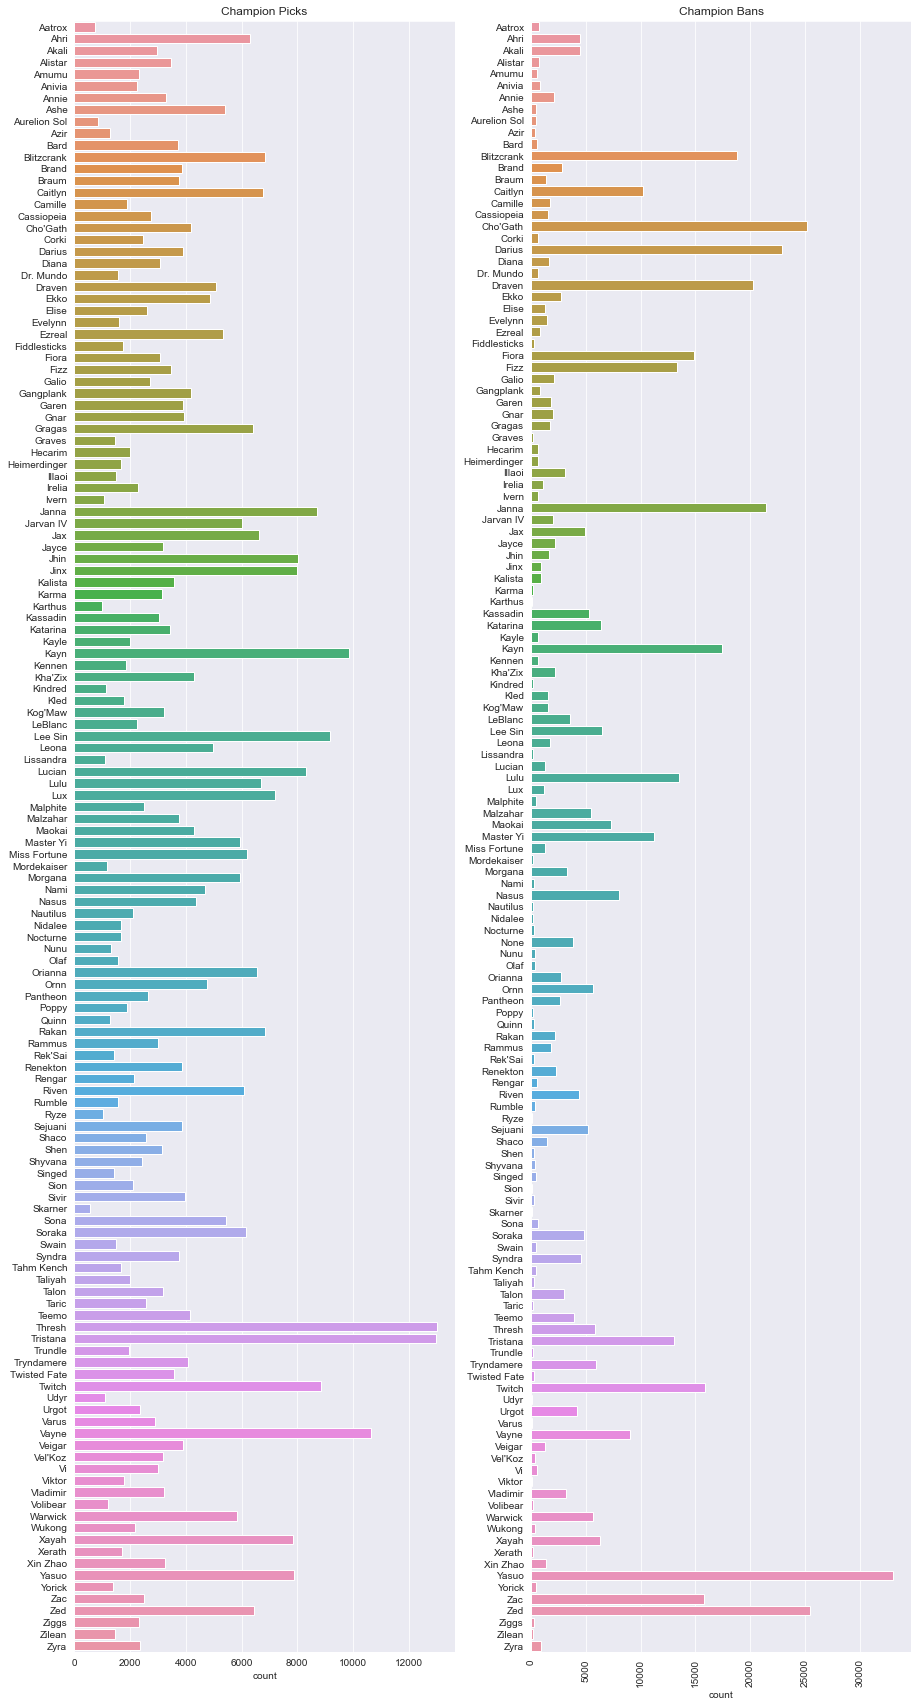

In [29]:
fig, (ax1,ax2) = plt.subplots(ncols=2,sharey=False,figsize=(15,30))
plt.xticks(rotation=90)
sns.countplot(y=sortedPicks,data=data,ax=ax1)
sns.countplot(y=sortedBans,data=data,ax=ax2)
ax1.set_title('Champion Picks')
ax2.set_title('Champion Bans')

쓰레쉬와 트리스타나가 얼마나 많은 인기를 얻었는지, 그리고 얼마나 많은 사람들이 야스오, 제드, 초가스, 다리우스를 상대하는 것을 싫어하는지 확인할 수 있다.

### 재미로 챔피언과 소환사의 주문 수를 계산한 그림입니다.

In [32]:
tagsCols=['t1_champ1id_tags','t1_champ2id_tags','t1_champ3id_tags',
         't1_champ4id_tags','t1_champ5id_tags','t2_champ1id_tags',
        't2_champ2id_tags','t2_champ3id_tags','t2_champ4id_tags',
        't2_champ5id_tags']

In [33]:
tagsTotals=data[tagsCols].apply(pd.value_counts)
tagsTotals['count']=tagsTotals[tagsCols].sum(axis=1)
tagsTotals

,t1_champ1id_tags,t1_champ2id_tags,t1_champ3id_tags,t1_champ4id_tags,t1_champ5id_tags,t2_champ1id_tags,t2_champ2id_tags,t2_champ3id_tags,t2_champ4id_tags,t2_champ5id_tags,count
Fighter,13362,12767,12961,12893,13530,13282,12998,13000,12897,13394,131084
Marksman,11413,12144,11939,12063,11247,11511,11939,11888,12062,11340,117546
Mage,9151,8674,8420,8591,8816,9016,8680,8716,8615,8776,87455
Support,6260,6790,6902,6887,6533,6491,6902,6843,6834,6654,67096
Tank,6130,6219,6421,6249,6142,6098,6174,6257,6233,6232,62155
Assassin,5174,4896,4847,4807,5222,5092,4797,4786,4849,5094,49564


<AxesSubplot:ylabel='count'>

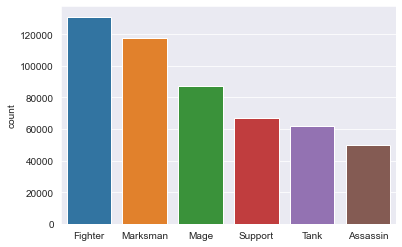

In [35]:
sns.barplot(x=tagsTotals.index,y=tagsTotals['count'])

### 각 스펠을 얼마나 많이 드는지 확인

In [36]:
spellsTotals=data[sumSpellsCols].apply(pd.value_counts)
spellsTotals['count']=spellsTotals[sumSpellsCols].sum(axis=1)
spellsTotals

,t1_champ1_sum1,t1_champ1_sum2,t1_champ2_sum1,t1_champ2_sum2,t1_champ3_sum1,t1_champ3_sum2,t1_champ4_sum1,t1_champ4_sum2,t1_champ5_sum1,t1_champ5_sum2,...,t2_champ1_sum2,t2_champ2_sum1,t2_champ2_sum2,t2_champ3_sum1,t2_champ3_sum2,t2_champ4_sum1,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,count
Barrier,702,890,649,814,620,852,630,834,648,814,...,881,637,887,617,823,634,838,625,804,14880
Cleanse,160,199,151,153,135,168,136,134,125,182,...,190,129,159,136,182,154,181,149,184,3154
Exhaust,3640,4394,3904,4614,3928,4738,3992,4723,3763,4557,...,4459,3912,4596,3928,4704,3855,4717,3885,4511,84576
Flash,28164,22216,27998,22490,28019,22397,27988,22393,27966,22377,...,22204,28037,22427,28170,22255,28089,22322,27838,22589,504121
Ghost,744,798,678,706,647,750,664,689,720,800,...,761,715,706,690,712,672,737,665,711,14305
Heal,4581,5758,4922,6309,4902,6180,4971,6136,4500,5826,...,5934,4854,6197,4834,6173,4896,6276,4571,5746,108043
Ignite,3820,5205,3832,4930,3786,4894,3777,4982,3917,5093,...,5047,3823,4875,3758,4980,3715,4899,3956,5032,88258
Smite,4711,5635,4780,5520,4789,5511,4681,5579,4768,5550,...,5656,4690,5558,4621,5594,4894,5594,4777,5563,103062
Teleport,4968,6395,4576,5954,4664,6000,4651,6020,5083,6291,...,6358,4693,6085,4736,6067,4581,5926,5024,6350,109401


<AxesSubplot:ylabel='count'>

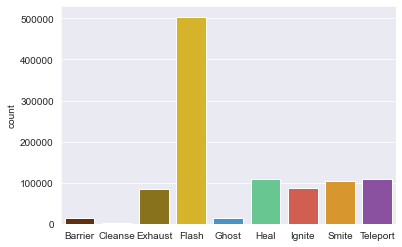

In [37]:
spellColors=["#6E2C00","#1A5276","#9A7D0A","#F1C40F","#3498DB","#58D68D","#E74C3C","#F39C12","#8E44AD"]
sns.barplot(x=spellsTotals.index,y=spellsTotals['count'],palette=spellColors)

점멸이 가장 많이 사용되는 것을 확인할 수 있다.

### 누가 대부분 첫번째 오브젝트를 얻는지 확인해봅시다
나중에 플롯을 더 쉽게 하기 위해 팀 컬러를 값으로 하는 새로운 데이터 프레임을 만들어야 합니다.

In [38]:
dataClean=data.replace([0,1,2],['neither','blue','red'])
dataClean.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t1_champ1id_tags,t1_champ2id_tags,t1_champ3id_tags,t1_champ4id_tags,t1_champ5id_tags,t2_champ1id_tags,t2_champ2id_tags,t2_champ3id_tags,t2_champ4id_tags,t2_champ5id_tags
0,3326086514,1504279457970,1949,9,blue,red,blue,blue,blue,blue,...,Mage,Support,Marksman,Assassin,Mage,Marksman,Marksman,Fighter,Assassin,Support
1,3229566029,1497848803862,1851,9,blue,blue,blue,blue,neither,blue,...,Marksman,Fighter,Assassin,Fighter,Assassin,Tank,Mage,Fighter,Fighter,Fighter
2,3327363504,1504360103310,1493,9,blue,red,blue,blue,blue,red,...,Marksman,Fighter,Support,Fighter,Assassin,Mage,Support,Fighter,Fighter,Marksman
3,3326856598,1504348503996,1758,9,blue,blue,blue,blue,blue,blue,...,Tank,Mage,Marksman,Mage,Fighter,Mage,Fighter,Support,Fighter,Marksman
4,3330080762,1504554410899,2094,9,blue,red,blue,blue,blue,blue,...,Fighter,Marksman,Support,Marksman,Mage,Support,Tank,Fighter,Assassin,Marksman


### 여기서는 원하는 열을 가져와서 값 카운트를 가져온 다음 그림을 더 깔끔하게 표시하기 위해 다시 인덱싱합니다.

In [39]:
firsts=['firstBlood','firstTower','firstInhibitor','firstBaron','firstDragon','firstRiftHerald']
firstTotals=dataClean[firsts].apply(pd.value_counts)
newIndex=['blue','red','neither']
firstSort=firstTotals.reindex(index=newIndex)
firstSort

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald
blue,26113,25861,23054,14758,24690,12948
red,24822,24416,22160,16474,24800,12363
neither,555,1213,6276,20258,2000,26179


### 플롯의 경우 사용자 지정 색상 팔레트를 작성한 다음 for 루프가 있는 하위 그림을 작성합니다.

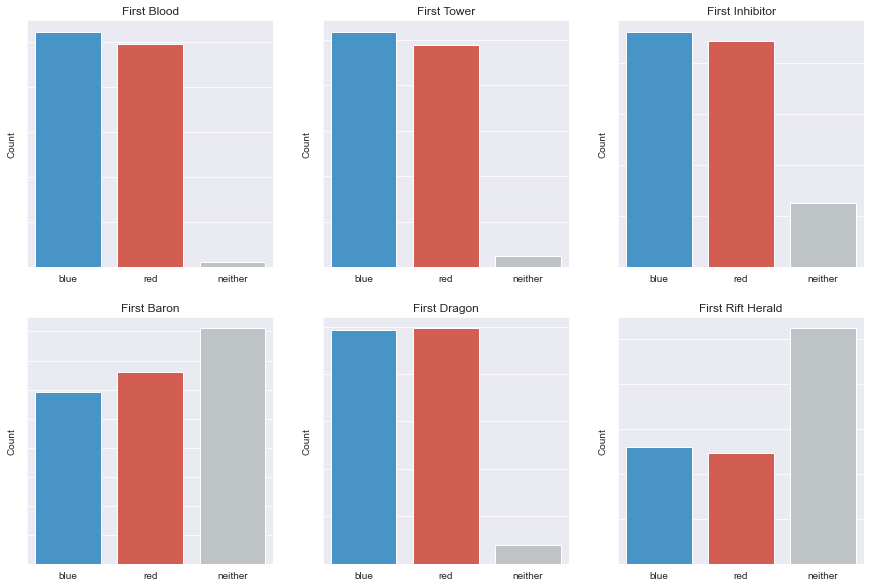

In [41]:
plotColors = ['#3498DB','#E74C3C','#BDC3C7']
firstLabels=['First Blood','First Tower','First Inhibitor','First Baron','First Dragon','First Rift Herald']
nrows,ncols=2,3
fig=plt.figure(figsize=(15,10))
for i in range(1,7):
    ax=fig.add_subplot(nrows,ncols,i)
    sns.barplot(x=firstSort.index,y=firstSort[firstSort.columns[i-1]],palette=plotColors)
    ax.set_ylabel('Count')
    ax.yaxis.set_ticklabels([])
    ax.set_title(firstLabels[i-1])

neither : 얻지 않고 끝난 경우

신기하네요. 몇 가지 요점은 다음과 같습니다.

대부분의 플롯은 비슷하지만, 초대 남작의 차이는 남작 핏이 레드 베이스와 가깝고, 그들의 위치 때문에 훔치기가 쉽기 때문일 수도 있다.

초대 남작을 뽑는 'neither' 카운트는 절반 이상의 경기가 남작을 빼앗기지 못한 채 끝났다는 것을 보여준다.

퍼스트 블러드는 약간 블루팀에 유리합니다. 아마도 정글 컨트롤 측면에서 블루팀이 초반 우위를 점하고 있는 것 아닐까?